---
# Plankton Recognition Challenge
---


# Group 20 : Solution
## by Maxence Brugeres, Martin Guyard and Clément Bernard   


The aim of this notebook is to work with Plankton population. Indeed, this population has a key role to predict the world's ocean health. Our goal is therefore to use the data available in order to accurately predict and classify plankton properties. 

We had three different approaches to deal with this problem. 


    
-  The first was to use provided features like a classic approach to such a problem.
- The second one to extract more features from images and use a classic approach
- The last one to use images and DeepLearning 

    
We had to make a choice and we decided, for the sake of learning differents things through the challenges, to deal with the **DeepLearning** approach. 

As adviced, we'll use the **level2** hierarchy, which is in other words a multi classification problem with 39 different labels.


# 1. Data pre-processing

This section explains how we dealt the images in order to use them as inputs for our algorithm

## 1.1 Labels unbalanced

The data is very unbalanced. There is one class, the **detritus** class, which has more than 139 000 images corresponding. 

We can't afford this, our algorithm will have too much issues to deal with these unbalanced classes.

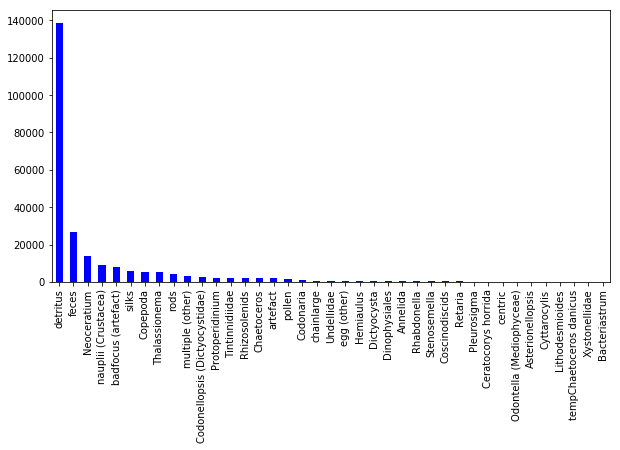

In [6]:
# Plot of the distribution of the classes

Furthermore, there are around 240 000 images. This will induce high computation cost, which should be take into account.

One idea is to do data cleaning and data augmentation. 

## 1.2 Data cleaning 

First, NaN values should be treated. There are few inputs that have NaN values for the label (level2 column).

They are dropped for sake of time (they only represent 0.5% of the dataset)


## 1.3 Resizing

The images don't all have the same shape and size, thus they are padded to be squarred and then resized to the size 32x32 pixels.

This resizing might appear brutale, yet it is motivated by two main reasons:
- Such a resizing will reduce the space required for the data
- It will also reduce the amount of computational ressources required, which is the main problem we are facing in this challenge.

The main problem caused by such a resize is the loss of information, for instance down below it is clear that the smoothness of the plankton's skin can't be determined after the resize for instance :


<table><tr><td><img src='./ilustr/non_pixeled.png' width=200></td><td><img src='ilustr/pixeled_img.png' width=200></td></tr></table>

## 1.4 Split into training, validation and testing set

Since there is hundred of thousands samples, splitting the set in a 20%, 20% and 60% samples for testing, validation and training set is not necessarily relevant.

Indeed, event taking 90%-5%-5% for the train, validation and test sets will lead to significative amount of sample in testing and validation set. Yet, since this split is done before the data augmentation, the classes are still really imbalanced. To make sure each classes will be correctly represented in the testing and validation set, we perform a 80%-10%-10% split. Then a bit of data augmentation is done to solve the imbalance problem.




## 1.5 Data augmentation

First, the unbalanced class should be treated first. 

To do this, there are two main possibilities : 

- Improve the numbers of other classes
- Remove part of the images with this unbalanced label

Both are done : reduce the number of data with this unbalanced labels and then improve the data for other labels.

A number of sample per classes is fixed. On the one hand, if a classes has more sample than this number, some are randomly dropped to get to the right amount, here 8000 samples per classes. After this step, the distribution looks like that:

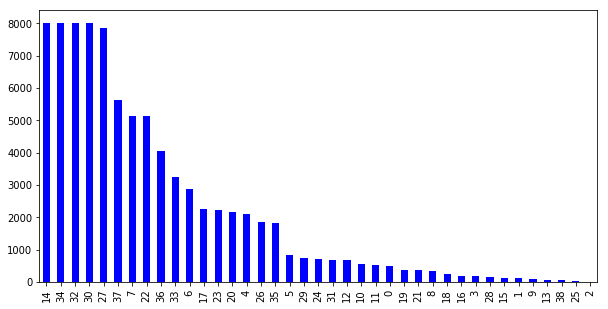

In [12]:
meta.level2.value_counts().plot(kind='bar', color = 'b',figsize=(10,5))

On the other hand, if a classes has less samples, oversampling is performed as follows, to get each classes to the same cardinality.

Each images of the classes are transformed a little bit by performing:
- rotation (from 0 to 20 degrees)
- translation (from -3 to 3 pixels)
- horizontal and vertical flip
- transposition
- tampering with the colors (add noise)

For instance, bellow are the original image and some examples of its transformatoins

<table><tr><td><img src='./ilustr/oversampled.png' width=300></td><td><img src='./ilustr/origin.png' width=200></td></tr></table>

In the end the training set is composed of 250000 samples

## 2. Model selection

### 2.1 Metric 

For this challenge, one can't only rely on the **accuracy**. 

For instance, if we had 100 patients that have a cancer, and the accuracy of an algorithm is 90. Then, it would still have 10 patients that have cancer but not predicted by the algorithm, which is not acceptable.

In our case, this is the health of the ocean which is at stake. The same argument works as well. 

A metric that takes into account the disparity between classes is required. 

One metric can be the **recall** which is : 

$$ Recall = \frac{TP}{TP + FN}$$

It can be summarized as a measure of the correctly identified postive cases from all the predicted positive cases. 

Another metric could be the **Precision** : 

$$ Precision = \frac{TP}{TP + FP}  $$

It can be explained as a measure of correctly identified positive cases from all the positive cases. 

Finally, the metrics to use will be a mix of both these metrics, called **f1 score** : 

$$  f1 = (\frac{Recall^{-1} + Precision^{-1}}{2})^{-1} =  2 \frac{Precision \times Recall}{Precision + Recall}        $$

It gives a better measure of the incorrectly classified classes than the accuracy.


<hr>


A way to deal with image classification is with DeepLearning.

Indeed, as there are a lot of data, Neural Networks can learn much more than with fewer data. 

Our approach is thus the following : 

- Use a simple Neural Network to see how a very basic do on this data. 
- Try to create a custom architecture with CNNs, some regularization (with dropout) and optimizer selection (Adam, Stochastic,...)
- Use Transfer Learning 



### 2.2 Simple Neural Network

The first architecture used is a simple fully connected neural network.
After 500 epochs and a batch-size of 500 (for the gradient optimization), the f1 score, even if it has improved, is not improving enough.

As expected the results are not good since a simple neural network can't really gather the information about each pixels and its environment in the same time. This pushes toward the use of a convolutional neurol network.

Here is a plot of the Loss and F1 score through the epochs : 

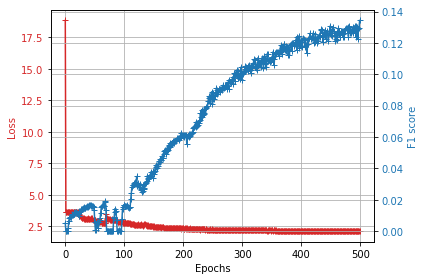

### 2.3 Custom Convolutional Neural Network


A CNN might a more suited solution for this problem since it involves images. Getting inspiration from a LeNet5 neural network and testing some changes in it, we came out with the following structure.

There are seven layers:
- Convolution with five 5x5 filters. The output uses a rectified linear unit activation since it takes non linearities into account
- Maxpooling returning 15x15 output
- Convolution with ten 4x4 filters. Also ReLU activation
- Maxpooling returning 8x8 output
- A BatchNormalization to limit covariate shift
- Flattening layer
- Fully connected layer with 39 outputs as there are 39 classes. A softmax activation function is used as it is performing well on non-binary classification (sigmoid should be used in binary classification)

<img src='./ilustr/CNN.png' width=300>

The chosen loss is the categorical_crossentropy as it is recommended for multi classes classification. The optimizer is adam, a stochastic gradient based method. 
<br>Several passes of training were done, increasing the batch_size (for the optimizer then) each time to make the convergence more accurate (but slower).

The first passes leads to this graph:

<img src='./ilustr/cnn_train.png' width=400>

For instance, during one of the passes the result can be summarized as displayed above. After only ten epochs, yet with a small batch_size, the f1 score and loss start to reach a plateau. This might be the sign that the accuracy delivered by the gradient computation in the optimizer is no high enough to this point. Thus another pass can be done increasing the batch_size (then the gradient is computed over a larger amount of samples, it is thus more accurate).

This process is repeated adapting the number of epoch to the batch_size since a large batch_size often requires a large number of epochs to converge.

In the end, the training f1_score hits 0.40. Yet the validation score only reaches 0.31. This might be the sign of overfitting, some methods could be use to limit overfitting such as dropout for instance.

31200/31200 [==============================] - 13s 410us/step
Loss on the validation set : 1.835644955635071
F1 score for validation set : 0.30861295515910175


Dropout is added as follows:
- Convolution with five 5x5 filters. Drop connections with 10% chances
- Maxpooling returning 15x15 output
- Convolution with ten 4x4 filters Drop connections with 10% chances
- Maxpooling returning 8x8 output
- A BatchNormalization to limit covariate shift
- Flattening layer and drop connections with 15% chances
- Fully connected layer with 39 outputs as there are 39 classes. A softmax activation function is used as it is performing well on non-binary classification (sigmoid should be used in binary classification)

In the end the training f1 score hits 0.39 but the validation is indead improved and hits 35.

31200/31200 [==============================] - 10s 323us/step
Loss on the validation set : 1.7538850847727214
F1 score for validation set : 0.3544450066257746


### 2.4 Transfer Learning 

As the creation of custom neural network for this kind of problem may take too much time, we decided to use works from others. Some researchers have already trained Deep Neural Network to identify, classify, detect specific objects in images. 

Our idea is therefore to use one of this architecture and its parameters to be able to detect some specific shapes in our images. Then, we aim to add few layers to :
- change the output to be adequate to our targets 
- fit well with our problems. 

This is what we call **Transfer Learning**

**VGG16**  is a convolutional neural network model that achieved 92.7% on top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. 

Here is the architecture : 

<img src='./ilustr/vgg16.png' width=500>


It could therefore be usefull to use the first layers of this model to extract information from our data, and then add a fully connected layer to create relation to our problem. Then, another output is load to be adequate to our 39 labels. 

There are few ways to use transfer learning. We could, for instance : 
- Load the layers and the weights as an initialization and then train with our data
- Load the layers of the VGG16 and freeze all the weights in order to fine-tune the rest to fit well our data.

We decided to use the second one. Indeed, it will require less time and be less cost computing to train.


Here is a summary of our final network : 

In [25]:
# Summary of our transfer - fine-tuned network

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1, 1, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 39)                49959     
Total params: 2,307,943
Trainable params: 49,959
Non-trainable params: 2,257,984
_________________________________________________________________


We first tried to run through 50 epochs. It ended by overfitting the training set too much.

Therefore, we reduced the number of epochs to 20. 

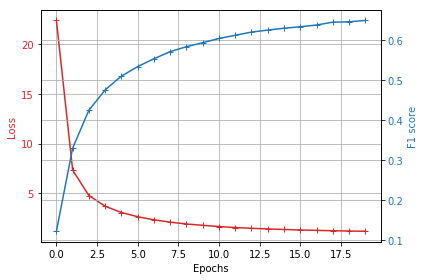

In [28]:
# Plot of the loss and epoch for the transfered model

It ended by a f1 score of **0.66** on the training set. Nevertheless, the score on the validation set is **0.54** which is an overfitting case too. 

## 3. Final Prediction

### 3.1 Final score 

Let's summarise the results we got so far 

In [103]:
# Summary of our previous results 

,Simple Neural Network,Custom CNN,Custom CNN Dropout,Transfer Learning fine-tuned
Loss,2.32,1.83,1.75,1.71
F1 score,0.11,0.31,0.35,0.54


We can see that the best results in the validation set are obtained with, as we could have thought, the fine-tuned model.

It means the the layers from the VGG16 succeeded quite well to extract some basic features from the images.

We can therefore choose this model to predict on the test set : 

Prediction on the test :
Loss : 1.6875102722491973
F1 score :0.5667461156845093


We see that the final f1 score is still lower than the train f1 score, certainly due to overfitting. 

Nevertheless, it remains quite good compared to the previous models we got. 

The final test score is therefore **0.57**

### 3.2 Comparison with simple featured approach

In order to have an idea of our results, one can think of a very basic approach with features that were given.

To do so, the unbalanced data is dropped such as the number of data in this label is equal to the second top label. 

Then, the NaN values are filled by 0 and the categorical values are either converted or dropped. 

For instance, one can convert the date by taking the starting point as the minimum data available, and then count the number of days from this start. It allows to convert the time we had.

Finally, a **Random Forest Classifier** has been applied. Here is the result on the validation set : 

Model used : Random Forest


,Training set,Validation set
F1 score,0.999747,0.762654


The final f1 score on the test set is : **0.76**

## Conclusion



Our DeepLearning approach seems to be quite limited. Indeed, a features-based approach had better results, which can be explained by the fact the the experts who have generated these features have summarized all the most relevant features. 

Nevertheless, the DeepLearning approach is limited by the restriction we had. The choices we made were all oriented to keep the computation cost acceptable, and we didn't have time to run too much epoch for the training. 




## 4. Critics 

The scores we got can be explained by few limitations. Indeed, these are the problems we encountered :  


- Computation cost prevented us to perform well
- Time issue : we didn't have time to run for few days our models
- Memory issues : we didn't have the capacity to store large images and so have better resolution and so results

Thus, we had to make some choices than could have lowered our models, such as : 

- Size of the images : we lost a lot of information by doing a resize
- Unbalanced labels : we dropped a lot of data. We could have found another way not to waste this information
- Regularisation and validation : we didn't try all the methods to avoid overfitting. We mainly used dropout.
- We had issues with the running time and therefore had to reduce the size of the dataset, which led to results from different number of images. 



